*This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Asa Ben-Hur.
The content is availabe [on GitHub](https://github.com/asabenhur/CS345).*

*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<img style="padding: 10px; float:right;" alt="CC-BY-SA icon.svg in public domain" src="https://upload.wikimedia.org/wikipedia/commons/d/d0/CC-BY-SA_icon.svg" width="125">


<a href="https://colab.research.google.com/github//asabenhur/CS345/blob/master/notebooks/module05_01_logistic_regression.ipynb">
  <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%autosave 0
%matplotlib inline

Autosave disabled


# Logistic Regression

Although its name would suggest otherwise, logistic regression is a classification method.
As we go along, it may become clear why the word regression is in there.

### Recap:  linear classifiers

In earlier notebooks we discussed the use of a linear function to make predictions using a linear function:

$$
f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x} + b.
$$

The class associated with $\mathbf{x}$ is decided according to the sign of the discriminant function $f(\mathbf{x})$.

For example:

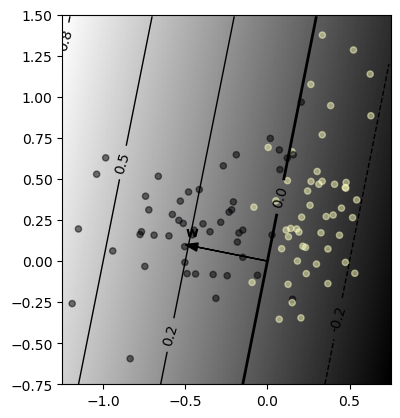

In [324]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, n_classes=2, n_clusters_per_class=1, class_sep=0.3, random_state=1)
plt.style.use('default')
plt.scatter(X[:,0], X[:,1], c=1-y, alpha=0.5, s=20, cmap='magma');

w = np.array([-0.5, 0.1])
b = 0
delta = 0.01
xmin=-1.25;xmax=0.75;ymin=-0.75;ymax=1.5
xs = np.arange(xmin, xmax, delta)
ys = np.arange(ymin, ymax, delta)
x_grid, y_grid = np.meshgrid(xs, ys)

Z = w[0] * x_grid + w[1] * y_grid + b
    
im = plt.imshow(Z, origin='lower',
                cmap=plt.cm.gray, extent=(xmin,xmax,ymin,ymax) )

C = plt.contour(x_grid, y_grid, Z, 5, 
                origin='lower',
                linewidths=(1,1,2,1,1),
                colors = 'black')

plt.clabel(C, inline=1, fmt='%1.1f')

plt.arrow(0,0,w[0],w[1], width=0.001,head_width=0.05, length_includes_head=True, alpha=1,linestyle='-',color='k');
plt.text(w[0], w[1]+0.05, r"$\mathbf{w}$");


### Using probabilities to quantify prediction confidence

As users of machine learning, we are interested in making *confident* predictions.  In the context of the linear discriminant function,
the magnitude of $f(\mathbf{x})$ can tell us something about our confidence in the prediction.  However, there is no easy way for us to interpret that value as a measure of confidence.  What would help us is a way to estimate $p(y | \mathbf{x})$.

In this notebook we will focus on binary classification problems.  In this case the only two options are $p(y=1 | \mathbf{x})$, and $p(y=0 | \mathbf{x})$, which satisfy:

$$
p(y=0 | \mathbf{x}) = 1 - p(y=1 | \mathbf{x})
$$

The following figure shows $p(y=1 | \mathbf{x})$ and $p(y=0 | \mathbf{x})$ for a hypothetical classification problem.

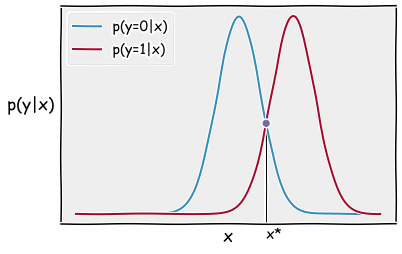

In [2]:
from scipy.stats import norm
plt.style.use('bmh')
plt.xkcd(scale=0.3)
plt.figure(figsize=(6,4))
m1 = 2.5
std1 = 1.0
m2 = 5.0
std2 = 1.0
def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])
result=solve(m1,m2,std1,std2)
x = np.linspace(-5,9,10000)
ax = plt.axes()
ax.plot(x,norm.pdf(x,m1,std1),label="p(y=0|x)")
ax.plot(x,norm.pdf(x,m2,std2),label="p(y=1|x)")
ax.plot(result,norm.pdf(result,m1,std1),'o')
plt.xlabel('x')
plt.ylabel('p(y|x)',rotation=0,labelpad=30)
ax.arrow(result[0],norm.pdf(result,m1,std1)[0],0,-2,head_width=0, head_length=0 ,fc='k', ec='k',color="yellow")
plt.text(result[0], -0.05, "x*")
plt.xticks([])
plt.yticks([])
plt.legend();

In the above figure, $\mathbf{x}^*$ is the point where 
$P(y=1 | \mathbf{x}) = P(y=0 | \mathbf{x})$.  To the right of it, we would classify examples as belonging to the positive class, and negative to the left.

We would like to learn to predict a probability $ p(y | \mathbf{x})$  for a binary classification problem using a linear classifier.
A dot product prduces arbitrary numbers, so cannot serve to produce probabilities because they need to be between 0 and 1.
However, we can convert a dot product to a probability by applying a "squashing function" to the dot product e.g. using the so-called **logistic function**:

$$
p(y=1|\mathbf{x})= \frac{1}{1 + e^{-\mathbf{w}^\top \mathbf{x}}}.
$$

The logistic function is defined by:

$$
\sigma(s) = \frac{1}{1 + e^{-s}}.
$$

We can express the probability in terms of the function $\sigma$:

$$
p(y|\mathbf{x})= \begin{cases}    \sigma(\mathbf{w}^\top \mathbf{x}) & \textrm{for} \space {y}=1 \newline
1- \sigma(\mathbf{w}^\top \mathbf{x}) \space & \textrm{for} \space {y}=0
\end{cases}
$$

Let's take a look at the graph of the logistic function (aka the sigmoid function), which demonstrates its ability to serve as a "squashing function":

In [3]:
def sigmoid(s):
    return 1/(1+np.exp(-s))

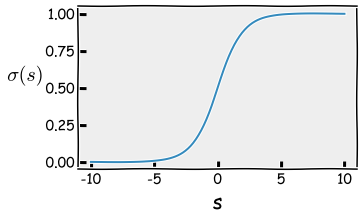

In [8]:
s = np.linspace(-10,10, 100)
plt.figure(figsize=(5,3))
plt.plot(s, sigmoid(s))
plt.xlabel("s", fontsize=20)
plt.ylabel(r"${\sigma}(s)$", rotation=0, fontsize=20, labelpad=20);


The choice of the logistic function seems arbitrary so we will motivate it.

First, instead of trying to predict $p(y=1|\mathbf{x})$, let's consider

$$\frac{p(y=1|\mathbf{x})}{p(y=0|\mathbf{x})} = \frac{p(y=1|\mathbf{x})}{1- p(y=1|\mathbf{x})}.$$

This is called the **odds**.

What did we gain?  Whereas $p(y=1|\mathbf{x})$ is a number between 0 and 1, the odds is a number between 0 and infinity.

That's an improvement, but again there's no natural way to model that using a dot product.  So instead, we will focus on the log odds:

$$\log \frac{p(y=1|\mathbf{x})}{p(y=0|\mathbf{x})} = \log \frac{p(y=1|\mathbf{x})}{1- p(y=1|\mathbf{x})} .$$

The log-odds is between negative infinity, and infinity and can therefore be modeled using a dot product.

For your reference, here's a nice [video](https://www.youtube.com/watch?v=ARfXDSkQf1Y) that explains odds and odds ratios.

Our choice to model the log-odds using a dot product gives the following:

$$\log \frac{p(y=1|\mathbf{x})}{1- p(y=1|\mathbf{x})} = \mathbf{w}^\top \mathbf{x}.$$

Solving for $p(y=1|\mathbf{x})$ we find that 

$$
p(y=1|\mathbf{x})= \frac{1}{1 + e^{-\mathbf{w}^\top \mathbf{x}}}.
$$

In conclusion, the choice to model the log-odds ratio using a dot product gave us the motivation to use the logistic function as a "squashing function" to generate a probability from a dot product.

#### Exercise

Check that solving for $p(y=1|\mathbf{x})$ in
$$\log \frac{p(y=1|\mathbf{x})}{1- p(y=1|\mathbf{x})} = \mathbf{w}^\top \mathbf{x}$$ indeed gives us
$$
p(y=1|\mathbf{x})= \frac{1}{1 + e^{-\mathbf{w}^\top \mathbf{x}}}.
$$

### Exercise: Properties of the logistic function

Verify that:

$$
\sigma(s) = \frac{1}{1+e^{-s}} = \frac{e^s}{1+e^s}
$$

$$
1- \sigma(s) = \sigma(-s) = \frac{1}{1+e^{s}}
$$

$$
\sigma'(s) = \sigma(s)(1-\sigma(s))
$$

The following figure plots these functions: 

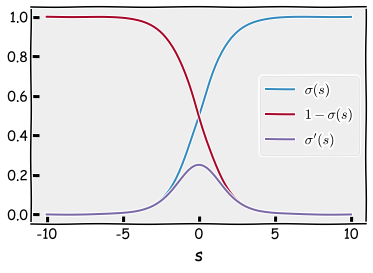

In [9]:
s = np.linspace(-10,10, 100)
plt.plot(s, sigmoid(s), label = r'$\sigma(s)$')
plt.plot(s, 1-sigmoid(s), label = r'$1-\sigma(s)$')
plt.plot(s, sigmoid(s) *(1-sigmoid(s)), label = r"$\sigma'(s)$")

plt.xlabel("s")
plt.legend();

### Is logistic regression really linear?

Given that the dot product is squashed using a non-linear function, it's not clear that the resulting classifier is indeed linear.  To answer this question, we first observe that

$$
p(y=1|\mathbf{x})=\frac{e^{\mathbf{w}^\top \mathbf{x}}}
{e^{\mathbf{w}^\top \mathbf{x}}+1} 
$$

$$
{p(y=0|\mathbf{x})}=1-{p(y=1|\mathbf{x})}=\frac{1}{1 + e^{\mathbf{w}^\top \mathbf{x}}} 
$$

To  figure  out  how  the  decision  boundary  looks  like, we consider the following equation:

$$
p(y=1|\mathbf{x})=p(y=0|\mathbf{x})
$$


Solving for $\mathbf{x}$ we get that
$
e^{\mathbf{w}^\top \mathbf{x}}=1
$
i.e. the points on the decision boundary satisfy
$
\mathbf{w}^\top \mathbf{x}=0 
$, which is th equation for a hyperplane.

Here's a plot that illustrates that:


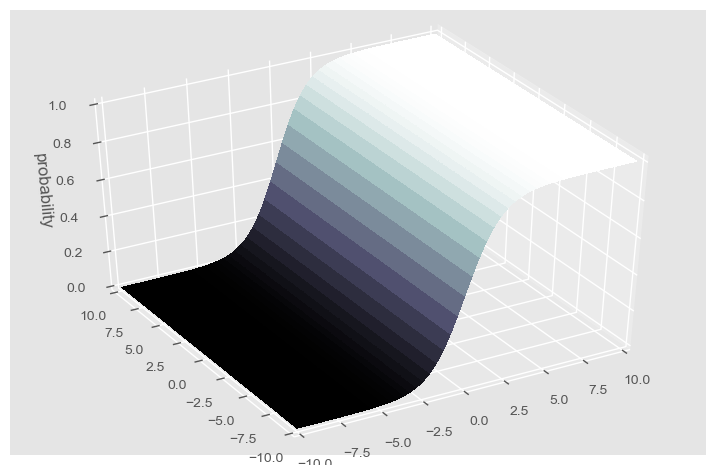

In [298]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.style.use('ggplot')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = np.linspace(-10, 10, 1000)
X1, Y1 = np.meshgrid(X, X )

Z = sigmoid1(X1)
surf=ax.plot_surface(X1,Y1,Z,linewidth=0, cmap=plt.get_cmap('bone'), antialiased=False)

ax.set_zlim(0, 1.01)
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.set_zlabel('probability',rotation=0)
ax.view_init(azim = 180+60, elev = 40)

### Maximum likelihood

We have expressed our classification problem in the language of probabilities, and therefore, we will apply the principle of *maximum likelihood* in order to find the optimal value of the weight vector 
$\mathbf{w}$.

The likelihood function is the probability of the labels $y_1,\ldots,y_N$ given the corresponding $\mathbf{x}_1,\ldots, \mathbf{x}_N$:

\begin{equation}
p(y_1,\ldots,y_N | \mathbf{x}_1,\ldots, \mathbf{x}_N) = \prod_{i=1}^{N} p({y_i| \mathbf{x}_i}).
\end{equation}

This is valid because of the assumption that the data points
$(\mathbf{x}_1,y_1),\ldots,(\mathbf{x}_N,y_N)$ are independent, a standard assumption in machine learning.

The likelihood function depends on the values of model parameters, and using maximum likelihood we seek to find the parameter values that maximize the likelihood function over all choices of those parameters.
Intuitively, this selects the parameter values that make the observed data most probable.

Let's define $p_i = p(y_i = 1 | \mathbf{x}_i)$.
Using this notation we can express $p({y_i| \mathbf{x}_i})$ as follows:

$$
p({y_i| \mathbf{x}_i}) = p_i^{y_i} (1- p_i)^{1-y_i}.
$$

This assumed the choice of $y_i$ to be 0 or 1 for our binary classification problem.
We are going to need the negative log of this probability:

$$
- \log p({y_i| \mathbf{x}_i}) = - y_i \log p_i - (1-y_i) \log(1- p_i)
$$

Recall that

$$
p(y=1|\mathbf{x}) = \sigma(\mathbf{x}^\top\mathbf{w}) = \frac{1}{1 + e^{-\mathbf{w}^\top \mathbf{x}}}.
$$

And inserting the form of $p({y_i| \mathbf{x}_i})$:

$$
- \log p({y_i| \mathbf{x}_i}) = - y_i \log \left( \sigma(\mathbf{w}^\top \mathbf{x}_i) \right) - (1-y_i) \log \left(1 - \sigma(\mathbf{w}^\top \mathbf{x}_i)\right)
$$



### Maximizing the likelihood

We would like to find the weight vector that maximizes the likelihood of the data, i.e. find
$$
\max_{\mathbf{w}} \prod_{i=1}^{N}p(y_i|\mathbf{x}_i)
$$
This is equivalent to maximizing the log-likelihood (since the logarithm is a monotonic function): 
$$
\max_{\mathbf{w}} \ln \prod_{i=1}^{N}p(y_i| \mathbf{x}_i)
$$
The logarithm of a product is a sum of the logs of the terms so our objective becomes

$$
\max_{\mathbf{w}} \sum_{i=1}^{N}\ln p(y_i|\mathbf{x}_i)
$$

We'll replace maximization with minimization by considering

$$
\min_{\mathbf{w}} -\frac{1}{N}\sum_{i=1}^{N}\ln(p(y_i|\mathbf{x}_i))
$$

Using the form we derived above for $p({y_i| \mathbf{x}_i})$

$$
- \log p({y_i| \mathbf{x}_i}) = - y_i \log \left( \sigma(\mathbf{w}^\top \mathbf{x}_i) \right) - (1-y_i) \log \left(1 - \sigma(\mathbf{w}^\top \mathbf{x}_i)\right)
$$

our objective now becomes:

$$
\min_{\mathbf{w}} -\frac{1}{N}\sum_{i=1}^{N} \left[ - y_i \log \left( \sigma(\mathbf{w}^\top \mathbf{x}_i) \right) - (1-y_i) \log \left(1 - \sigma(\mathbf{w}^\top \mathbf{x}_i)\right) \right]
$$

Let's take a closer look at the expression we derived for $- \log p({y_i| \mathbf{x}_i})$.  And let's consider the case $y_i = 1$.  In that case, only the first term is nonzero.  When the predicted probability is equal to 1, which is what we would like, it is equal to 0, and the further away from the desired value it is, the larger the value.  A similar observation occurs for $y_i=0$:  In this case only the second term contributes, and this term equals to 0 when the predicted probability is equal to 0, which is the desired value for negative examples.  Thus, the function

$$
\mathcal{l}^{CE}(y,\mathbf{x}; \mathbf{w}) = - y \log \left( \sigma(\mathbf{w}^\top \mathbf{x}) \right) - (1-y) \log \left(1 - \sigma(\mathbf{w}^\top \mathbf{x})\right) 
$$

which is known as the **cross entropy loss** or **log loss** quantifies  the discrepancy of predicted probability from the desired label, and indeed functions like a loss function.

Let's plot this function for $y = 1$ and $y=0$:

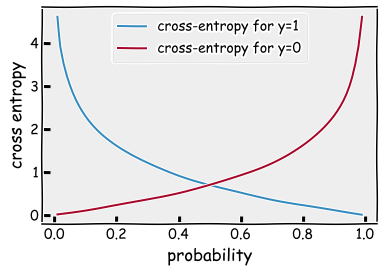

In [10]:
def cross_entropy(p, y):
    return -(y*np.log(p)+(1-y)*np.log(1-p))

p = np.linspace(0.01, 0.99, 100)
plt.plot(p, cross_entropy(p, 1), label='cross-entropy for y=1')
plt.plot(p, cross_entropy(p, 0), label='cross-entropy for y=0')

plt.xlabel('probability')
plt.ylabel('cross entropy')
plt.legend();

### Logistic regression loss

We have finally arrived at the final form of the loss function for logistic regression:

$$
J(\mathbf{w}) = -\frac{1}{N}\sum_{i=1}^{N} \left[ - y_i \log \left( \sigma(\mathbf{w}^\top \mathbf{x}_i) \right) - (1-y_i) \log \left(1 - \sigma(\mathbf{w}^\top \mathbf{x}_i)\right) \right]
$$

Unlike the case of linear regression where there is a closed-form solution, there is no such solution for the logistic regression loss function.  It turns out that the loss function is convex, and therefore there is a global minimum.  Gradient descent is therefore a reasonable approach.

The gradient of our loss function is:
$$
\nabla J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^{N} \left(\sigma(\mathbf{w}^\top \mathbf{x}_i) - y_i\right) \mathbf{x}_i
$$


### Gradient descent 

1. initialize $\mathbf{w}(0)$.
2. for t = 0, 1, 2,... do
3. $\;\;\;\;\;\;$       compute the gradient: $\mathbf{g}_t$ = $\nabla  J(\mathbf{w}(t))$
4. $\;\;\;\;\;\;$       update the weights: $\mathbf{w}(t + 1) = \mathbf{w}(t) - \eta \mathbf{g}_t$
5. $\;\;\;\;\;\;$       if it is time to stop, break from loop.
6. end for
7. return the final weights.

This is called **batch gradient descent**.
The halting condition can be a specific number of iterations, or that the loss function appears to have converged, i.e. shows little change across iterations.

### Implementation

Let's implement our gradient descent logistic regression algorithm as a Python class.

In [20]:
class logistic_regression:
    def __init__(self, lr=0.01, change=0.0001):
        self.lr = lr
        self.change = change

    def decision_function(self, X):
        return 1/(1+np.exp(-np.inner(self.w, X)))

    def gradient(self, X, y): 
        return (self.decision_function(X) - y)@X/len(X)
  
    def loss(self, X, y):
        pred = self.decision_function(X) 
        loss_values = - y * np.log(pred) - (1 - y) * np.log(1 - pred)
        return np.mean(loss_values) 
  
    def fit(self, X, y): 
        self.w = np.zeros(X.shape[1])
        loss = self.loss(X, y)
        self.loss_history = [loss]
        change = 1       
        while(change > self.change):
            old_loss = loss
            self.w = self.w - self.lr * self.gradient(X, y)
            loss = self.loss(X, y)
            self.loss_history.append(loss)
            change = old_loss - loss
         
    def predict(self, X): 
        pred = np.where(self.decision_function(X) >= .5, 1, 0) 
        return np.squeeze(pred) 


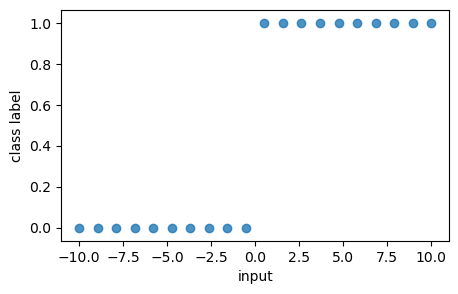

In [11]:
N = 20
X = np.linspace(-10,10,20)
y=np.where(X>=0, 1, 0)
X=X.reshape(-1, 1)

plt.style.use('default')
plt.figure(figsize=(5,3))
plt.scatter(X, y, alpha=0.8)
plt.xlabel("input")
plt.ylabel("class label");

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
    test_size=0.2, shuffle=True)

In [21]:
lgr=logistic_regression()
lgr.fit(X_train,y_train)

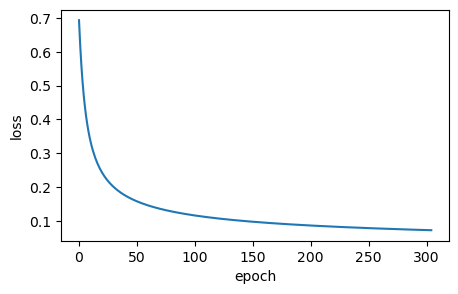

In [18]:
plt.figure(figsize=(5,3))
plt.plot(lgr.loss_history)
plt.ylabel('loss')
plt.xlabel('epoch');

In [22]:
y_pred=lgr.predict(X_test)
print('accuracy: ', np.sum(y_pred == y_test)/len(y_test))

accuracy:  1.0


In [26]:
from sklearn.datasets import make_classification
X,y = make_classification(n_samples=100, n_features=2, n_informative=2, 
                          n_redundant=0, n_repeated=0, n_classes=2, 
                          n_clusters_per_class=1, class_sep=0.3, 
                          random_state=1)
lr=logistic_regression()
lr.fit(X, y)
y_pred=lr.predict(X)
print('accuracy: ', np.sum(y_pred == y)/len(y))

accuracy:  0.9


Let's plot the resulting decision boundary and weight vector:

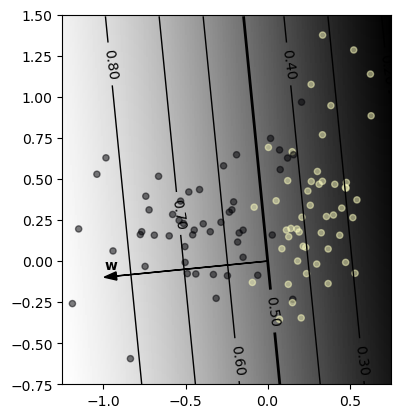

In [27]:

plt.style.use('default')
plt.scatter(X[:,0], X[:,1], c=1-y, alpha=0.5, s=20, cmap='magma');

w = lgr.w/np.linalg.norm(lgr.w)

delta = 0.01
xmin=-1.25;xmax=0.75;ymin=-0.75;ymax=1.5
xs = np.arange(xmin, xmax, delta)
ys = np.arange(ymin, ymax, delta)
x_grid, y_grid = np.meshgrid(xs, ys)

Z = sigmoid(lgr.w[0]*x_grid + lgr.w[1]*y_grid)

im = plt.imshow(Z, origin='lower',
                cmap=plt.cm.gray, extent=(xmin,xmax,ymin,ymax) )

C = plt.contour(x_grid, y_grid, Z, 7, 
                origin='lower',
                linewidths=(1,1,1,1,2,1,1),
                colors = 'black')

plt.clabel(C, inline=1, fmt='%1.2f')

plt.arrow(0,0,w[0],w[1], width=0.001,head_width=0.05, length_includes_head=True, alpha=1,linestyle='-',color='k');
plt.text(w[0], w[1]+0.05, r"$\mathbf{w}$");


Text(0.5, 0, 'epoch')

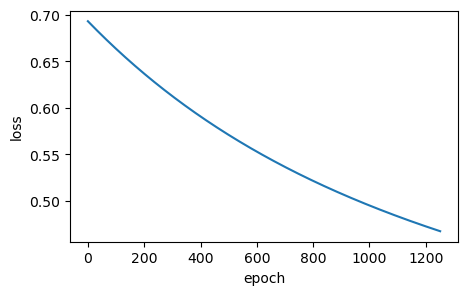

In [28]:
plt.figure(figsize=(5,3))
plt.plot(lgr.loss_history)
plt.ylabel('loss')
plt.xlabel('epoch')

### Logistic regression in scikit-learn

**Play with some real data**

Now using the Sklearn method of logistic regression

In [270]:
from sklearn import datasets, linear_model, metrics 
from sklearn.model_selection import train_test_split 

reg = linear_model.LogisticRegression() 
   
# train the model using the training sets 
reg.fit(X_train, y_train) 
  
# making predictions on the testing set 
y_pred1 = reg.predict(X_test) 
   
# comparing actual response values (y_test) with predicted response values (y_pred) 
print("Logistic Regression model accuracy(in %):",  
metrics.accuracy_score(y_test, y_pred1)*100) 


Logistic Regression model accuracy(in %): 100.0


### Stochastic gradient descent

In machine learning large training sets are necessary for good generalization.  But training models over large training sets is computationally expensive.
That has led to the development of alternatives to gradient descent.
Stochastic gradient descent is one such algorithm, and is the basis for many of the commonly used algorithms in deep learning.

The cost functions used in machine learning typically decompose as a sum or average over the loss for individual training examples.
This is the case for logistic regression where the overall loss is the average of individual loss values:

$$ 
J(\mathbf{w})= \frac{1}{N}\sum_{i=1}^N \mathcal{l}^{CE}(y_i,\mathbf{x}_i; \mathbf{w}),
$$

where

$$
\mathcal{l}^{CE}(y,\mathbf{x}; \mathbf{w}) = - y \log \left( \sigma(\mathbf{w}^\top \mathbf{x}) \right) - (1-y) \log \left(1 - \sigma(\mathbf{w}^\top \mathbf{x})\right).
$$

The gradient of $J(\mathbf{w})$ is an average over the gradients of the contributions of individual training examples.
For large datasets, this average is expensive to compute.
The key insight, is that this mean can be estimated using a smaller number of examples.
The intuition why this is possible is that in practice, examples are often highly correlated, so you don't need to use all of them to get a reasonable estimate of the gradient.  This idea is implemented using the technique of **stochastic gradient descent (SGD)**.

The batch version of SGD uses a small  subset (or *batch*) of randomly chosen examples $\mathcal{B}$ which is a subset of the entire training set $\mathcal{D}$.  The gradient is estimated as the mean of the gradients over the examples that make up the batch:

$$
\mathbf{g} = \frac{1}{|\mathcal{B}|}\sum_{i\in \mathcal{B}} \nabla \mathcal{l}(y_i,\mathbf{x}_i; \mathbf{w}),
$$

where $\mathcal{l}(y_i,\mathbf{x}_i; \mathbf{w})$ is the loss function and $|\mathcal{B}|$ is the cardinality of the set $\mathcal{B}$.

#### Batch stochastic gradient descent 

Input:  learning rate, $\eta$.
1. initialize weights $\mathbf{w}$
2. for t = 0, 1, 2,... do
3. $\;\;\;\;\;\;$       partition the data into fixed-size batches $\mathcal{B}_1,\ldots,\mathcal{B}_b$
4. $\;\;\;\;\;\;$       for j = 1,...,b :  # loop over batches:
5. $\;\;\;\;\;\;\;\;\;$       compute the gradient over batch j: $\mathbf{g} = \frac{1}{|\mathcal{B_j}|}\sum_{i\in \mathcal{B}_j} \nabla \mathcal{l}(y_i,\mathbf{x}_i; \mathbf{w})$
6. $\;\;\;\;\;\;\;\;\;$       update the weights: $\mathbf{w} = \mathbf{w} - \eta \mathbf{g}$
7. $\;\;\;\;\;\;$       if it is time to stop, break.
8. end for
7. return the final weights.

The extreme case where the batch size is equal to 1 will be called **stochastic gradient descent** (as opposed to batch sgd).  In this case the algorithm takes on the following form:

#### Stochastic gradient descent 

Input:  learning rate, $\eta$.
1. initialize weights $\mathbf{w}$
2. for t = 0, 1, 2,... do
3. $\;\;\;\;\;\;$       randomly shuffle the examples in the training set
4. $\;\;\;\;\;\;$       for i = 1,...,N :  # loop over the shuffled data
5. $\;\;\;\;\;\;\;\;\;$       compute the gradient example i: $\mathbf{g} = \nabla \mathcal{l}(y_i,\mathbf{x}_i; \mathbf{w})$
6. $\;\;\;\;\;\;\;\;\;$       update the weights: $\mathbf{w} = \mathbf{w} - \eta \mathbf{g}$
7. $\;\;\;\;\;\;$       if it is time to stop, break.
8. end for
7. return the final weights.

In regular gradient descent, the loss function is guaranteed to decrease at each epoch (as long as the learning rate is sufficiently small).
This is no longer the case for SGD.  However, SGD will usually converge faster overall.


### Exercise:

Implement stochastic gradient descent and compare its convergence to that of batch gradient descent by plotting the loss function after each epoch.


In [ ]:
class sgd_lr :
    pass

### Comments:

1. In practice logistic regression is solved by faster methods than gradient descent 

2. There is an extension to multi-class classification 


### Advantages of logistic regression:

- Interpretable
- Fast training and prediction
- No tuning required
- Can perform well for small datasets
- Produces well-calibrated probabilities as output

### Disadvantages of logistic regression:

- Assumes a linear relationship between the features and the log-odds of class membership
- Performance is often not competitive with the best supervised learning methods
- Sensitive to irrelevant features

Note:  **Multinomial logistic regression** is used when there are more than two classes.
